# Retrospective analysis of a fairness violation in an income classification pipeline

When screening our [ML pipeline for income classification](https://github.com/schelterlabs/arguseyes-example/blob/main/pipelines/openml-classification-incomelevel.py) on Github with this [configuration](https://github.com/schelterlabs/arguseyes-example/blob/main/openml-classification-incomelevel-fairness.yaml), ArgusEyes detects a **fairness violation** in the pipeline. 

The screenshot shows the result of the [screening during the build triggered by a Github action](https://github.com/schelterlabs/arguseyes-example/actions/runs/3523396218/jobs/5907507086): The **classifier treats data from non-male person disparately unfair**, with respect to given threshold on the equal opportunity metric.

In the following, we show how to **leverage ArgusEyes to retrospectively analyze the pipeline run** (based on metadata and captured data artifacts), and **figure out the root cause of the fairness violation issue**.

![data-leakage-screening-via-a-github-action](github-action-fairness-screening.png)

### Load the metadata and artifacts from the original run of the pipeline

ArgusEyes needs the run id from the mlflow run where ArgusEyes stored the metadata and artifacts. (Note we use a local run here for demo purposes).

In [1]:
from arguseyes.retrospective import PipelineRun, FairnessRetrospective

run = PipelineRun(run_id='d0f8dbbe5ba340e89b869bd023e8c0c6')

### Interactively explore the dataflow plan and data of the pipeline run

We can view a dataflow plan of the pipeline, which highlights the input datasets, as well as the features and labels for the train and test data computed by the pipeline. We can interactively explore the pipeline data. Clicking on the pink data vertices provides us with details about the corresponding data.

<span style='color: red;'>[Note that this interactive widget is only shown during the actual execution of the notebook with jupyter and not rendered in the offline view on Github.]</span>

In [2]:
run.explore_data()

# Pipeline Data Explorer

## Retrospective analysis of the label errors issue

ArgusEyes allows us to instantiate a special `FairnessRetrospective`, which helps us understand the predictions of the pipeline with respect to different demographic groups.

In [3]:
retrospective = FairnessRetrospective(run)

Fairness in ML is typically defined with respect to a privileged group and a disadvantaged group. These groups are identified in the training data by examining a privileged value (e.g., 'male') for a sensitive attribute (e.g., 'sex'). The retrospective tells us for which group definitions we computed fairness metrics.

In [5]:
retrospective.fairness_criteria()

{('race', 'white'), ('sex', 'male')}

## Group-wise confusion matrices

ArgusEyes allows data scientists to conduct a deep dive into the fairness of the pipeline. We can for example compute and inspect the confusion matrices for the test predictions of the pipeline, separately for the protected and disadvantaged group. 

In [6]:
retrospective.show_confusion_matrix('sex', 'male')

,positive prediction,negative prediction,
positive label,TP=179,FN=206,385
negative label,FP=166,TN=813,979
,345,1019,
,positive prediction,negative prediction,
positive label,TP=141,FN=151,292
negative label,FP=121,TN=421,542
,262,572,


## Common fairness metrics

Additionally, ArgusEyes can compute and plot common fairness metrics for a given group definition. Negatively values in these metrics indicate unfairness, and we see that our pipeline is unfair with respect to non-male persons in the test data.

In [4]:
retrospective.fairness_metrics('sex', 'male')

{'predictive_parity': -0.019327359221152696,
 'equal_opportunity': -0.017941647393702187,
 'statistical_parity': -0.061216129735507774}

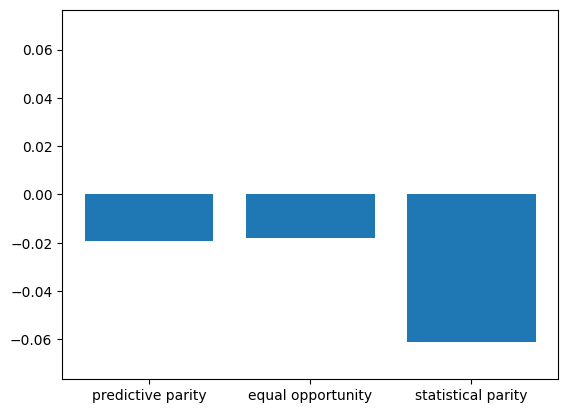

In [5]:
retrospective.plot_fairness_metrics('sex', 'male')

### Fixing the pipeline

In contrast to 'technical' issues like data leakage, fairness issues are much harder to fix, as they might not have a technical root cause, but might be a result of bias in the data, bias in the world or an inappropriate formalisation of a problem. In general fairness issues require consultation of legal experts and domain experts.

If the root cause of unfairness is non-representative training data, then a pipeline can be fixed by increasing the training data to include more diverse and representative samples.